In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import copy
from functools import partial

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.slicing.slice_model import SliceModel
from metal.mmtl.slicing.moe_model import MoEModel

from metal.mmtl.trainer import MultitaskTrainer
from metal.mmtl.slicing.synthetics.mmtl_utils import create_tasks, create_payloads, train_slice_experts
from metal.mmtl.slicing.synthetics.data_generator import generate_data, get_circle_mask
from metal.mmtl.slicing.synthetics.viz import visualize_payload, visualize_predictions, visualize_attention, score_and_visualize

/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
from metal.utils import set_seed

seed = 444
set_seed(seed)

### Generate Synthetic Dataset
We aim to build a dataset with a linear decision boundary and an abnormal boundary around $x=0.25, y=0$.
We define this slice as our `critical_region`.

In [6]:
from functools import partial
flip_1 = partial(get_circle_mask, center=(0.25, 0), radius=0.2)
flip_2 = partial(get_circle_mask, center=(-0.3, -0.5), radius=0.15)

label_flips = {
    flip_1: 1,
    flip_2: 2
}
uid_lists, Xs, Ys = generate_data(N=5000, label_flips=label_flips)
task_name = "test_task"

#### Generate eval payload over the `critical_slice`

In [7]:
# targets all the data -- used to add the BASE labelset to payloads
identity_fn = lambda x: np.ones(x.shape[0], dtype=np.bool)
# NOTE: the slice function _imperfectly_ targets the critical slice area.
slice_1 = partial(get_circle_mask, center=(0.35, -0.1), radius=0.2)
slice_2 = partial(get_circle_mask, center=(-0.35, -0.4), radius=0.15)

remainder = lambda X: np.logical_not(np.logical_or(slice_1(X), slice_2(X)))

In [8]:
eval_payload = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=1000, 
   slice_funcs={"slice_1": slice_1, "slice_2": slice_2, "remainder": remainder}
#    slice_funcs={"slice_1": flip_1, "slice_2": flip_2}
)[2] # take test set

Vizualizing labelset_gold from payload_test


/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


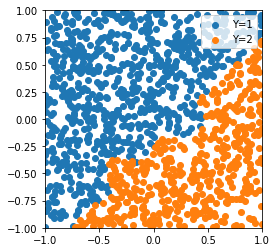

Vizualizing labelset:slice_1:pred from payload_test


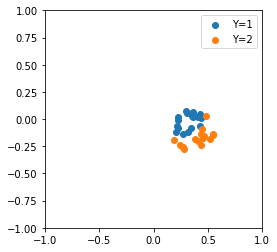

Vizualizing labelset:slice_1:ind from payload_test


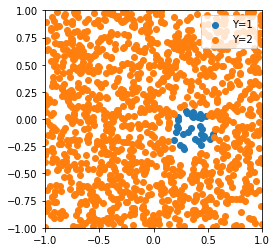

Vizualizing labelset:slice_2:pred from payload_test


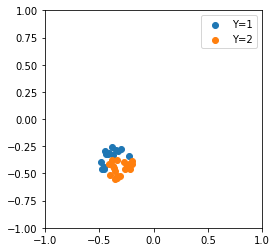

Vizualizing labelset:slice_2:ind from payload_test


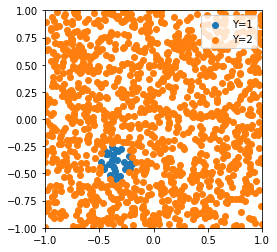

Vizualizing labelset:remainder:pred from payload_test


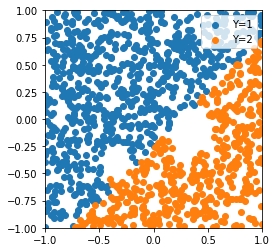

Vizualizing labelset:remainder:ind from payload_test


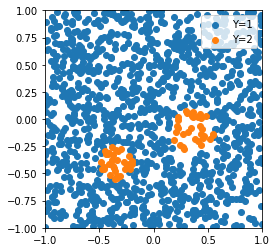

In [9]:
visualize_payload(eval_payload)

### Initialize and train each model type

In [13]:
# all models to test to test
all_slice_funcs = {"slice_1": slice_1, "slice_2": slice_2, "BASE": identity_fn}
slice_loss_multiplier = 1.0 / (2*len(all_slice_funcs))

model_configs = {
    'soft_param': {
        'slice_funcs': all_slice_funcs,
        'create_ind': True,
        'model_class': SliceModel,
        'slice_weights': {
            'BASE': slice_loss_multiplier,
            'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
        }
    },
     'hard_param': {
         'slice_funcs': all_slice_funcs,
         'create_ind': False,
         'model_class': MetalModel,
         'slice_weights': {'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier}
     },
     'manual_reweighting': {
         'slice_funcs': all_slice_funcs,
         'create_ind': False,
         'slice_weights': {"slice_1": 50}, # 10x weight of slice_2, everythign else default
         'model_class': MetalModel        
     },
     'moe': {
         'slice_funcs': {},
         'create_ind': False,
         'model_class': MoEModel
     },
#     'naive': {
#         'slice_funcs': {},
#         'model_class': MetalModel   
#     }
}

In [11]:
train_kwargs = {
    "lr": 0.01, 
    "n_epochs": 300,
    "checkpoint_best": False,
    "log_every": 5.0,
    "writer": "tensorboard", 
    "verbose": True,
    "progress_bar": False
}

==========Initializing + Training soft_param==========
Creating 7 tasks...
BinaryClassificationTask(name=test_task, loss_multiplier=1.00, slice_head_type=None)
BinaryClassificationTask(name=test_task:slice_1:pred, loss_multiplier=0.17, slice_head_type=pred)
BinaryClassificationTask(name=test_task:slice_1:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:slice_2:pred, loss_multiplier=0.17, slice_head_type=pred)
BinaryClassificationTask(name=test_task:slice_2:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:BASE:pred, loss_multiplier=0.17, slice_head_type=pred)
BinaryClassificationTask(name=test_task:BASE:ind, loss_multiplier=0.17, slice_head_type=ind)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:slice_1:pred': 'test_task:slice_1:pred', 'labelset:slice_1:ind': 'test_task:slice_1:ind', 'labelset:slice_2:pred': 'test_task:slice_2:pred', 'labelset:slice_2:i

/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


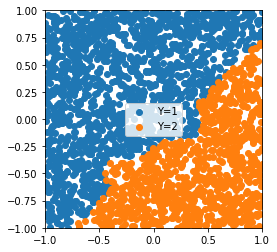

Vizualizing labelset:slice_1:pred from payload_train


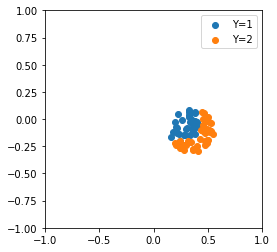

Vizualizing labelset:slice_1:ind from payload_train


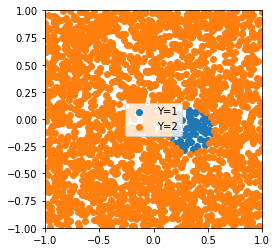

Vizualizing labelset:slice_2:pred from payload_train


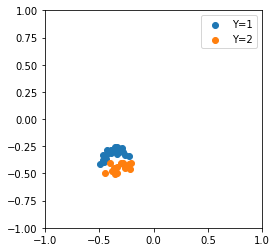

Vizualizing labelset:slice_2:ind from payload_train


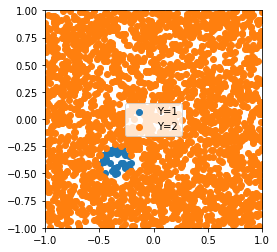

Vizualizing labelset:BASE:pred from payload_train


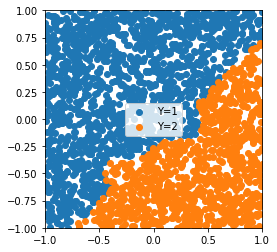

Vizualizing labelset:BASE:ind from payload_train


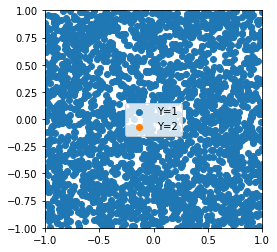

Beginning train loop.
Expecting a total of approximately 2512 examples and 157 batches per epoch from 1 payload(s) in the train split.
Writing config to /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_22_59/config.json
[5.0 epo]: test_task:[payload_train/labelset_gold/loss=1.50e-01, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.39e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.75e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=2.59e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.75e-03, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=8.80e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:

/lfs/1/jdunnmon/repos/metal/metal/mmtl/trainer.py:915: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'test_task/payload_test/labelset_gold/accuracy': 0.9872,
 'test_task:BASE:ind/payload_test/labelset:BASE:ind/accuracy': 1.0,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9656,
 'test_task:slice_1:ind/payload_test/labelset:slice_1:ind/accuracy': 0.992,
 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9705882352941176,
 'test_task:slice_2:ind/payload_test/labelset:slice_2:ind/accuracy': 0.9744,
 'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.78125}
Cleaning checkpoints
Writing metrics to /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_22_59/metrics.json
Writing log to /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_22_59/log.json
Full model saved at /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_22_59/model.pkl
{'test_task/payload_test/labelset_gold/accuracy': 0.9872, 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9705882352941176, 'test_task:slice_1:ind/payload_test/labelset:slice_1:ind/accura

/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


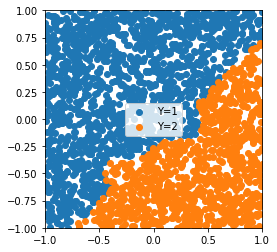

Vizualizing labelset:slice_1:pred from payload_train


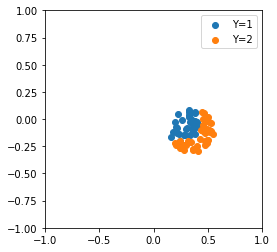

Vizualizing labelset:slice_2:pred from payload_train


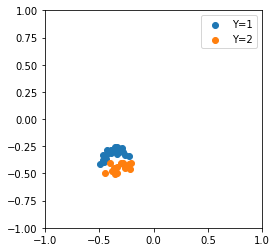

Vizualizing labelset:BASE:pred from payload_train


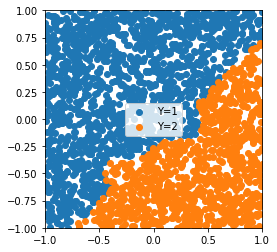

Beginning train loop.
Expecting a total of approximately 2512 examples and 157 batches per epoch from 1 payload(s) in the train split.
Writing config to /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_32_26/config.json
[5.0 epo]: test_task:[payload_train/labelset_gold/loss=1.57e-01, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.57e-01, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=8.66e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=9.57e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.55e-01, train/all/lr=1.00e-02, valid/all/loss=8.21e-02]
[10.0 epo]: test_task:[payload_train/labelset_gold/loss=8.40e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.40e-02, payload_valid/labelset:BASE

/lfs/1/jdunnmon/repos/metal/metal/mmtl/trainer.py:915: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'test_task/payload_test/labelset_gold/accuracy': 0.9632,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9632,
 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529,
 'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.8125}
Cleaning checkpoints
Writing metrics to /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_32_26/metrics.json
Writing log to /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_32_26/log.json
Full model saved at /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_32_26/model.pkl
{'test_task/payload_test/labelset_gold/accuracy': 0.9632, 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529, 'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.8125, 'test_task:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9632}
==========Initializing + Training manual_reweighting==========
Creating 4 tasks...
BinaryClassificationTask(name=test_task, loss_multip

/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


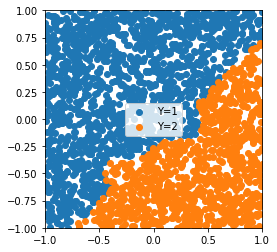

Vizualizing labelset:slice_1:pred from payload_train


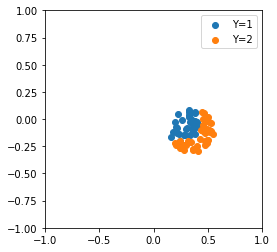

Vizualizing labelset:slice_2:pred from payload_train


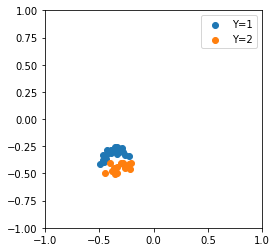

Vizualizing labelset:BASE:pred from payload_train


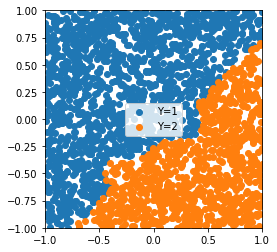

Beginning train loop.
Expecting a total of approximately 2512 examples and 157 batches per epoch from 1 payload(s) in the train split.
Writing config to /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_37_50/config.json
[5.0 epo]: test_task:[payload_train/labelset_gold/loss=1.74e-01, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.74e-01, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.55e+01, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.17e-01, payload_valid/labelset:slice_2:pred/accuracy=5.36e-01] model:[train/all/loss=5.58e-01, train/all/lr=1.00e-02, valid/all/loss=2.92e-01]
[10.0 epo]: test_task:[payload_train/labelset_gold/loss=8.94e-02, payload_valid/labelset_gold/accuracy=9.76e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.94e-02, payload_valid/labelset:BASE

/lfs/1/jdunnmon/repos/metal/metal/mmtl/trainer.py:915: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'test_task/payload_test/labelset_gold/accuracy': 0.9656,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9656,
 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9411764705882353,
 'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.84375}
Cleaning checkpoints
Writing metrics to /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_37_50/metrics.json
Writing log to /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_37_50/log.json
Full model saved at /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_37_50/model.pkl
{'test_task/payload_test/labelset_gold/accuracy': 0.9656, 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9411764705882353, 'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.84375, 'test_task:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9656}
==========Initializing + Training moe==========
Creating 1 tasks...
BinaryClassificationTask(name=test_task, loss_multiplier=1.00, sl

/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


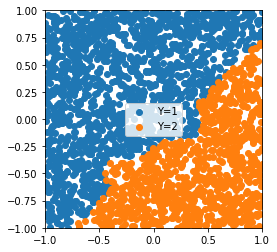

Creating 1 tasks...
BinaryClassificationTask(name=expert:slice_1:pred, loss_multiplier=1.00, slice_head_type=pred)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=train)
Payload(payload_valid: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=valid)
Payload(payload_test: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=test)
[BinaryClassificationTask(name=expert:slice_1:pred, loss_multiplier=1.00, slice_head_type=pred)]
[Payload(payload_train: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=train), Payload(payload_valid: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=valid), Payload(payload_test: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=test)]
Using GPU...

Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (expert:slice_1:pred): DataParallel(
      (module): Metal

/lfs/1/jdunnmon/repos/metal/metal/mmtl/trainer.py:915: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


Full model saved at /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_43_36/model.pkl
{'expert:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529}
Creating 1 tasks...
BinaryClassificationTask(name=expert:slice_2:pred, loss_multiplier=1.00, slice_head_type=pred)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset:slice_2:pred': 'expert:slice_2:pred'}], split=train)
Payload(payload_valid: labels_to_tasks=[{'labelset:slice_2:pred': 'expert:slice_2:pred'}], split=valid)
Payload(payload_test: labels_to_tasks=[{'labelset:slice_2:pred': 'expert:slice_2:pred'}], split=test)
[BinaryClassificationTask(name=expert:slice_2:pred, loss_multiplier=1.00, slice_head_type=pred)]
[Payload(payload_train: labels_to_tasks=[{'labelset:slice_2:pred': 'expert:slice_2:pred'}], split=train), Payload(payload_valid: labels_to_tasks=[{'labelset:slice_2:pred': 'expert:slice_2:pred'}], split=valid), Payload(payload_test: labels_to_tasks=[{'labelset:slice_2:pred': 'expert:

/lfs/1/jdunnmon/repos/metal/metal/mmtl/trainer.py:915: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


Writing metrics to /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_43_59/metrics.json
Writing log to /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_43_59/log.json
Full model saved at /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_43_59/model.pkl
{'expert:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.84375}
Creating 1 tasks...
BinaryClassificationTask(name=expert:BASE:pred, loss_multiplier=1.00, slice_head_type=pred)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset:BASE:pred': 'expert:BASE:pred'}], split=train)
Payload(payload_valid: labels_to_tasks=[{'labelset:BASE:pred': 'expert:BASE:pred'}], split=valid)
Payload(payload_test: labels_to_tasks=[{'labelset:BASE:pred': 'expert:BASE:pred'}], split=test)
[BinaryClassificationTask(name=expert:BASE:pred, loss_multiplier=1.00, slice_head_type=pred)]
[Payload(payload_train: labels_to_tasks=[{'labelset:BASE:pred': 'expert:BASE:pred'}], split=train), Payload(payload_valid: labels_to_tasks=[{'labelset:BASE:p

/lfs/1/jdunnmon/repos/metal/metal/mmtl/trainer.py:915: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


Full model saved at /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_44_18/model.pkl
{'expert:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9648}
Beginning train loop.
Expecting a total of approximately 2512 examples and 157 batches per epoch from 1 payload(s) in the train split.
Writing config to /lfs/1/jdunnmon/repos/metal/logs/2019_04_29/22_44_55/config.json


Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7ff335d5f570>
Traceback (most recent call last):
  File "/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/tqdm/_tqdm_notebook.py", line 226, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


RuntimeError: Expected object of backend CPU but got backend CUDA for argument #4 'mat1'

In [12]:
%%time
trained_models = {}
for model_name, config in model_configs.items():
    print(f"{'='*10}Initializing + Training {model_name}{'='*10}")
    slice_funcs = config['slice_funcs']
    model_class = config['model_class']
    slice_weights = config.get("slice_weights", {})
    create_ind = config.get("create_ind", True)
          
    tasks = create_tasks(
        task_name, 
        slice_names=list(slice_funcs.keys()), 
        slice_weights=slice_weights, 
        create_ind=create_ind,
        verbose=True
    )
    payloads = create_payloads(
        task_name, 
        uid_lists, 
        Xs, 
        Ys, 
        batch_size=16, 
        slice_funcs=slice_funcs, 
        create_ind=create_ind,
        verbose=True
    )
    visualize_payload(payloads[0])
          
    if model_name == 'moe':
        # train for total 300 epochs
        expert_train_kwargs = copy.deepcopy(train_kwargs)
        expert_train_kwargs['n_epochs'] = int(train_kwargs['n_epochs'] / (len(all_slice_funcs) + 1))
        experts = train_slice_experts(
            uid_lists, Xs, Ys, MetalModel, all_slice_funcs, **expert_train_kwargs
        )
        model = model_class(tasks, experts, verbose=False, seed=seed)
        trainer = MultitaskTrainer(seed=seed)
        metrics_dict = trainer.train_model(model, payloads, **expert_train_kwargs)
    else:
        model = model_class(tasks, verbose=False, seed=seed)
        trainer = MultitaskTrainer(seed=seed)
        metrics_dict = trainer.train_model(model, payloads, **train_kwargs)
    print(metrics_dict) 
    trained_models[model_name] = model

### Confirm that slice heads are actually experts at their jobs...

labelset 'labelset_gold' -> task 'None' (originally, test_task).
labelset 'labelset:remainder:pred' -> task 'None' (originally, test_task:remainder:pred).
labelset 'labelset:remainder:ind' -> task 'None' (originally, test_task:remainder:ind).
==========Evaluating soft_param==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': None,
    'labelset:slice_1:ind': 'test_task:slice_1:ind',
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': 'test_task:slice_2:ind',
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:ind/payload_test/labelset:slice_1:ind/accuracy': 0.992,
    'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9705882352941176,
    'test_task:slice_2:ind/payload_test/labelset:slice_2:ind/accuracy': 0.9744,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.78125}
Vizualizing test_task:slice_1:pre

/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


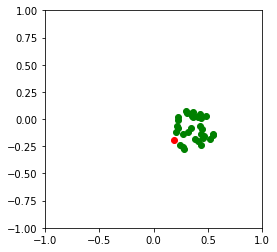

Vizualizing test_task:slice_1:ind predictions on labelset:slice_1:ind


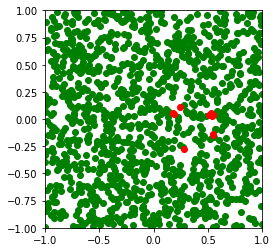

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


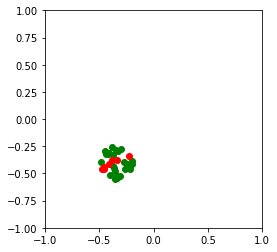

Vizualizing test_task:slice_2:ind predictions on labelset:slice_2:ind


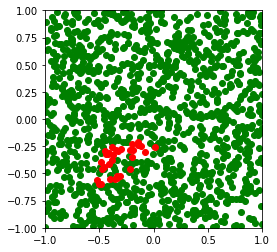

labelset 'labelset:slice_1:ind' -> task 'None' (originally, test_task:slice_1:ind).
labelset 'labelset:slice_2:ind' -> task 'None' (originally, test_task:slice_2:ind).
==========Evaluating hard_param==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': None,
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.8125}
Vizualizing test_task:slice_1:pred predictions on labelset:slice_1:pred


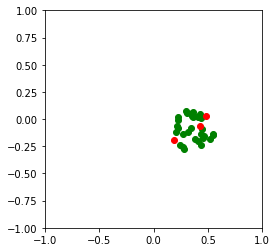

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


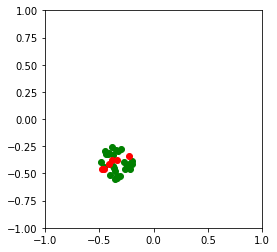

==========Evaluating manual_reweighting==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': None,
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9411764705882353,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.84375}
Vizualizing test_task:slice_1:pred predictions on labelset:slice_1:pred


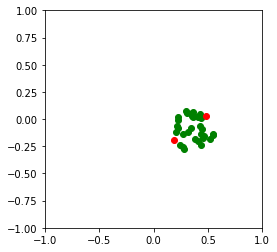

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


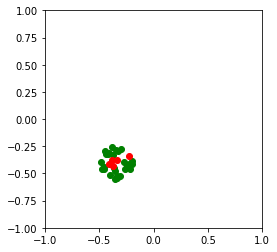

In [14]:
for model_name in model_configs.keys():
    if model_name == 'soft_param':
        labels_to_tasks = {
            "labelset:slice_1:pred": "test_task:slice_1:pred",
            "labelset:slice_2:pred": "test_task:slice_2:pred",    
            "labelset:slice_1:ind": "test_task:slice_1:ind",
            "labelset:slice_2:ind": "test_task:slice_2:ind",
        }
    else:
        labels_to_tasks = {
            "labelset:slice_1:pred": "test_task:slice_1:pred",
            "labelset:slice_2:pred": "test_task:slice_2:pred",        
        }

    eval_payload.remap_labelsets(labels_to_tasks)
    if model_name in ["hard_param", "soft_param", "manual_reweighting"]:
        print(f"{'='*10}Evaluating {model_name}{'='*10}")
        score_and_visualize(trained_models[model_name], eval_payload)

### Evaluate model on primary task head

labelset 'labelset_gold' -> task 'test_task' (originally, None).
labelset 'labelset:slice_1:pred' -> task 'test_task' (originally, test_task:slice_1:pred).
labelset 'labelset:slice_2:pred' -> task 'test_task' (originally, test_task:slice_2:pred).
labelset 'labelset:remainder:pred' -> task 'test_task' (originally, None).
==========Evaluating soft_param==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9932432432432432,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.8823529411764706,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.875,
    'test_task/payload_test/labelset_gold/accuracy': 0.9872}
Vizualizing test_task predictions on labelset_g

/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


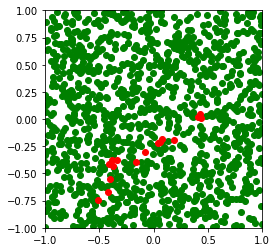

Vizualizing test_task predictions on labelset:slice_1:pred


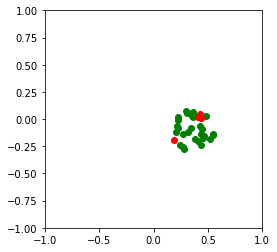

Vizualizing test_task predictions on labelset:slice_2:pred


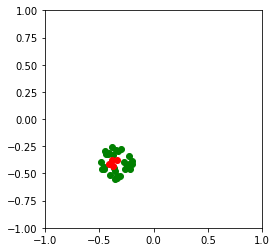

Vizualizing test_task predictions on labelset:remainder:pred


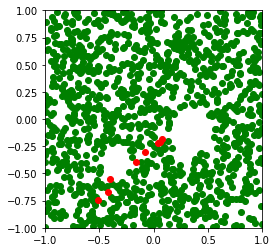

==========Evaluating hard_param==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9847972972972973,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.5294117647058824,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.625,
    'test_task/payload_test/labelset_gold/accuracy': 0.9632}
Vizualizing test_task predictions on labelset_gold


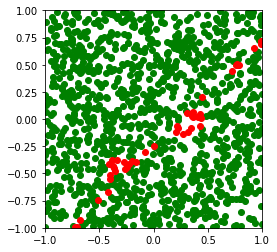

Vizualizing test_task predictions on labelset:slice_1:pred


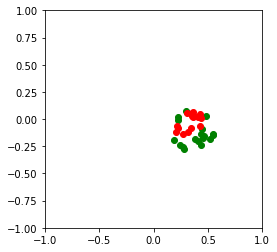

Vizualizing test_task predictions on labelset:slice_2:pred


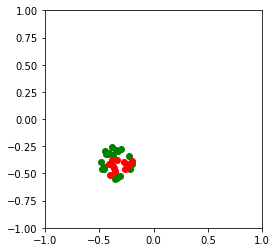

Vizualizing test_task predictions on labelset:remainder:pred


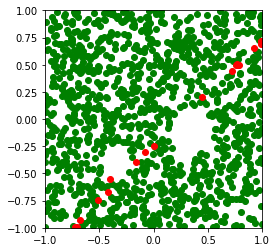

==========Evaluating manual_reweighting==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9890202702702703,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.5294117647058824,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.5625,
    'test_task/payload_test/labelset_gold/accuracy': 0.9656}
Vizualizing test_task predictions on labelset_gold


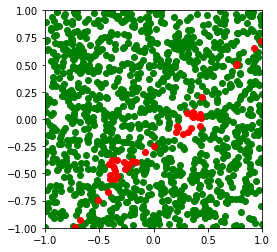

Vizualizing test_task predictions on labelset:slice_1:pred


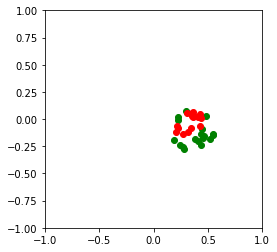

Vizualizing test_task predictions on labelset:slice_2:pred


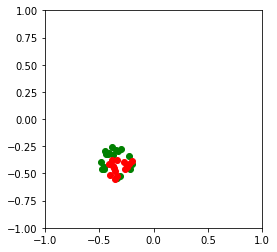

Vizualizing test_task predictions on labelset:remainder:pred


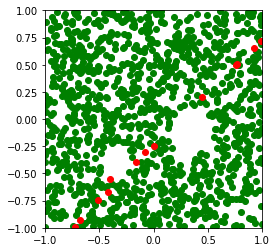

==========Evaluating moe==========


KeyError: 'moe'

In [15]:
# map all labelsets to the primary task_head 
eval_payload.remap_labelsets(labels_to_tasks= {
        "labelset_gold": "test_task",
        "labelset:slice_1:pred": "test_task",
        "labelset:slice_2:pred": "test_task",
        "labelset:remainder:pred": "test_task"
    }
)

for model_name in model_configs.keys():
    print(f"{'='*10}Evaluating {model_name}{'='*10}")
    score_and_visualize(trained_models[model_name], eval_payload)

### Visualize Attention Weights of `soft_param`

labelset 'labelset_gold' -> task 'None' (originally, test_task).
labelset 'labelset:slice_1:pred' -> task 'None' (originally, test_task).
labelset 'labelset:slice_1:ind' -> task 'test_task:slice_1:ind' (originally, None).
labelset 'labelset:slice_2:pred' -> task 'None' (originally, test_task).
labelset 'labelset:slice_2:ind' -> task 'test_task:slice_2:ind' (originally, None).
labelset 'labelset:remainder:pred' -> task 'None' (originally, test_task).
Vizualizing test_task:BASE:ind attention on labelset:slice_1:ind


/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


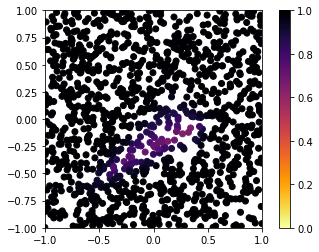

Vizualizing test_task:slice_1:ind attention on labelset:slice_1:ind


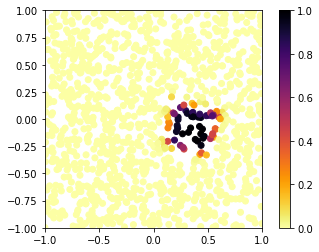

Vizualizing test_task:slice_2:ind attention on labelset:slice_1:ind


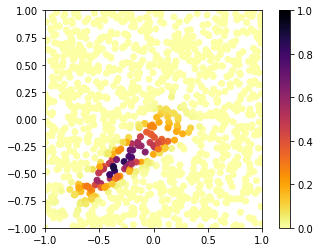

Vizualizing test_task:BASE:ind attention on labelset:slice_2:ind


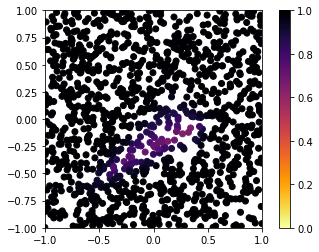

Vizualizing test_task:slice_1:ind attention on labelset:slice_2:ind


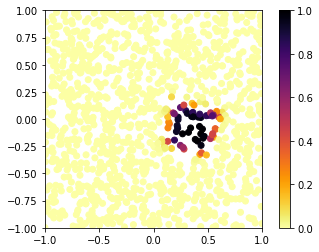

Vizualizing test_task:slice_2:ind attention on labelset:slice_2:ind


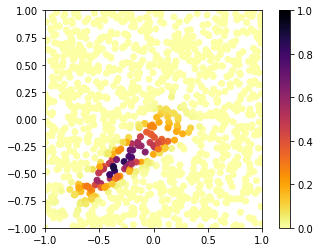

In [16]:
for model_name in trained_models.keys():
    if model_name != 'soft_param':
        continue

    eval_payload.remap_labelsets(labels_to_tasks = {
            "labelset:slice_1:ind": "test_task:slice_1:ind",
            "labelset:slice_2:ind": "test_task:slice_2:ind"
        }
    )

    visualize_attention(trained_models['soft_param'], eval_payload)